X_train shape: (36168, 37)
X_test shape: (9043, 37)
Random Forest - Training Accuracy: 0.9998592430403503
Random Forest - Test Accuracy: 0.8754837996240186
Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      7952
           1       0.47      0.29      0.36      1091

    accuracy                           0.88      9043
   macro avg       0.69      0.62      0.65      9043
weighted avg       0.86      0.88      0.86      9043



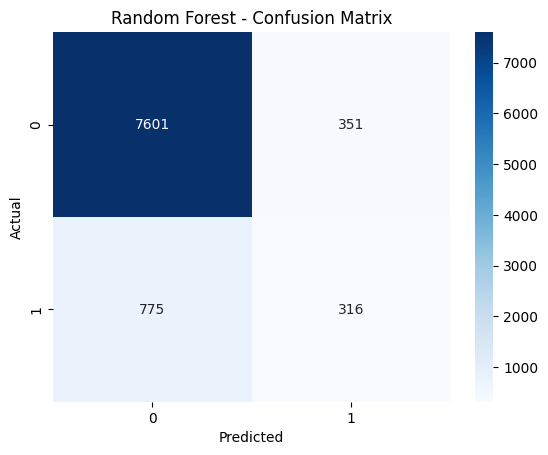

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best Parameters: {'class_weight': 'balanced_subsample', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Post-Tuning - Training Accuracy: 0.9998748827025337
Random Forest Post-Tuning - Test Accuracy: 0.8668583434700874
Random Forest Post-Tuning - Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93      7952
           1       0.41      0.22      0.29      1091

    accuracy                           0.87      9043
   macro avg       0.65      0.59      0.61      9043
weighted avg       0.84      0.87      0.85      9043



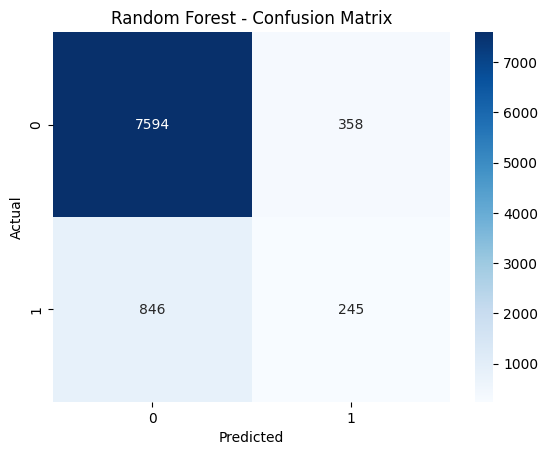

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

# Load the dataset 
data = pd.read_csv('processed_data_Encoding.csv')

# Separate features and target
X = data.drop('y', axis=1)  # Features
y = data['y']  # Target

# Specify numerical columns for scaling and PCA
numerical_cols = ['balance', 'campaign', 'previous']

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Apply scaling only to the specified numerical columns
scaler = StandardScaler()
X_train_scaled = X_train_res.copy()  # Copy to preserve other columns
X_test_scaled = X_test.copy()  # Copy to preserve other columns

# Scale only the numerical columns
X_train_scaled[numerical_cols] = scaler.fit_transform(X_train_res[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Apply PCA only to the scaled numerical columns
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled[numerical_cols])
X_test_pca = pca.transform(X_test_scaled[numerical_cols])

# Replace original numerical columns with PCA components in the scaled data
X_train_scaled[numerical_cols] = X_train_pca
X_test_scaled[numerical_cols] = X_test_pca

# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train_res)

# Make predictions
rf_y_pred_train = rf_model.predict(X_train_scaled)
rf_y_pred_test = rf_model.predict(X_test_scaled)

# Evaluate Model
print("Random Forest - Training Accuracy:", accuracy_score(y_train_res, rf_y_pred_train))
print("Random Forest - Test Accuracy:", accuracy_score(y_test, rf_y_pred_test))
print("Random Forest - Classification Report:")
print(classification_report(y_test, rf_y_pred_test))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, rf_y_pred_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='f1', verbose=2, n_jobs=-1)
grid_search.fit(X_train_res, y_train_res)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Get the best model from GridSearchCV
best_rf_model = grid_search.best_estimator_

# Make predictions with the tuned model
rf_tune_y_pred_train = best_rf_model.predict(X_train_res)
rf_tune_y_pred_test = best_rf_model.predict(X_test_scaled)

# Evaluate tuned model
print("Random Forest Post-Tuning - Training Accuracy:", accuracy_score(y_train_res, rf_tune_y_pred_train))
print("Random Forest Post-Tuning - Test Accuracy:", accuracy_score(y_test, rf_tune_y_pred_test))
print("Random Forest Post-Tuning - Classification Report:")
print(classification_report(y_test, rf_tune_y_pred_test))

# Confusion Matrix for tuned model
conf_matrix = confusion_matrix(y_test, rf_tune_y_pred_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
